In [61]:
!pip install TextBlob
!pip install unidecode
!pip install wordcloud
!pip install mglearn

  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582638 sha256=374b1bda26eeeb531308faaf5162163526b85d60bdc2025b2362f63a897f7536
  Stored in directory: c:\users\anast\appdata\local\pip\cache\wheels\87\75\37\404e66d0c4bad150f101c9a0914b11a8eccc2681559936e7f7
Successfully built mglearn


## Import libraries

In [1]:
import sys
# import libraries
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sqlalchemy import create_engine
import sqlite3
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nltk
import mglearn

nltk.download(['punkt', 'wordnet', 'stopwords'])
import re
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anast\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anast\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anast\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing training and test data set

In [2]:
columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text'] 
train_df = pd.read_csv('traindata.csv', header=None, names=columns)

In [3]:
train_df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Checking the data's output balance
# The label '4' denotes positive sentiment and '0' denotes negative sentiment
train_df['sentiment'].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

## Preprocessing 

In [5]:
#Drop features we don't need 
train_df = train_df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [6]:
# Separating positive and negative rows
df_pos = train_df[train_df['sentiment'] == 4]
df_neg = train_df[train_df['sentiment'] == 0]
print(len(df_pos), len(df_neg))

800000 800000


In [7]:
# Only retaining 1/4th of our data from each output group
# Feel free to alter the dividing factor depending on your workspace
# 1/64 is a good place to start if you're unsure about your machine's power
df_pos = df_pos.iloc[:int(len(df_pos)/5)]
df_neg = df_neg.iloc[:int(len(df_neg)/5)]
print(len(df_pos), len(df_neg))

160000 160000


In [8]:
# Concatinating both positive and negative groups and storing them back into a single dataframe
train_df = pd.concat([df_pos, df_neg])
len(train_df)

320000

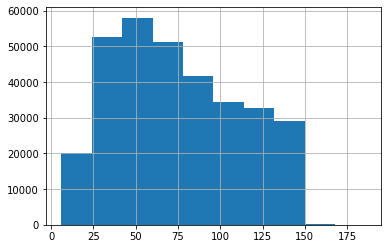

count    320000.000000
mean         74.094828
std          36.416134
min           6.000000
25%          44.000000
50%          69.000000
75%         104.000000
max         186.000000
dtype: float64

In [10]:
# Analyzing Train Tweet Length
#import pandas as pd
#import matplotlib.pyplot as plt
%matplotlib inline
tweets_len = [len(x) for x in train_df['text']]
pd.Series(tweets_len).hist()
plt.show()
pd.Series(tweets_len).describe()

### Normalisation, tokenization, lemmatization and removal of stopwords

In [11]:
train_df['sentiment_text'] = train_df['text'].str.replace('@','')
train_df['sentiment_text'] = train_df['sentiment_text'].str.replace(r'http\S+','')
train_df['sentiment_text'] = train_df['sentiment_text'].str.replace('[^a-zA-Z]',' ')

<ipython-input-11-de1aca11888d>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['sentiment_text'] = train_df['sentiment_text'].str.replace(r'http\S+','')
<ipython-input-11-de1aca11888d>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['sentiment_text'] = train_df['sentiment_text'].str.replace('[^a-zA-Z]',' ')


In [12]:
stopwords = stopwords.words('english')

In [13]:
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text

In [14]:
train_df['sentiment_text'] = train_df['sentiment_text'].apply(lambda text : remove_stopwords(text.lower()))

In [15]:
train_df['sentiment_text'] = train_df['sentiment_text'].apply(lambda x: nltk.word_tokenize(x))

In [16]:
train_df.head()

,sentiment,text,sentiment_text
800000,4,I LOVE @Health4UandPets u guys r the best!!,"[love, health, uandpets, u, guys, r, best]"
800001,4,im meeting up with one of my besties tonight! ...,"[im, meeting, one, besties, tonight, cant, wai..."
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S...","[darealsunisakim, thanks, twitter, add, sunisa..."
800003,4,Being sick can be really cheap when it hurts t...,"[sick, really, cheap, hurts, much, eat, real, ..."
800004,4,@LovesBrooklyn2 he has that effect on everyone,"[lovesbrooklyn, effect, everyone]"


In [17]:
wordnet=WordNetLemmatizer()
train_df['sentiment_text'] = train_df['sentiment_text'].apply(lambda x : [wordnet.lemmatize(i) for i in x])

In [18]:
train_df['sentiment_text'] = train_df['sentiment_text'].apply(lambda x : ' '.join([w for w in x]))

In [19]:
train_df['sentiment_text'] = train_df['sentiment_text'].apply(lambda x : ' '.join([w for w in x.split()]))

In [20]:
train_df.head()

,sentiment,text,sentiment_text
800000,4,I LOVE @Health4UandPets u guys r the best!!,love health uandpets u guy r best
800001,4,im meeting up with one of my besties tonight! ...,im meeting one besties tonight cant wait girl ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S...",darealsunisakim thanks twitter add sunisa got ...
800003,4,Being sick can be really cheap when it hurts t...,sick really cheap hurt much eat real food plus...
800004,4,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyone


In [23]:
#test_df['sentiment_text'] = test_df['text'].str.replace('@','')
#test_df['sentiment_text'] = test_df['sentiment_text'].str.replace(r'http\S+','')
#test_df['sentiment_text'] = test_df['sentiment_text'].str.replace('[^a-zA-Z]',' ')

In [24]:
#test_df['sentiment_text'] = test_df['sentiment_text'].apply(lambda text : remove_stopwords(text.lower()))

In [25]:
#test_df['sentiment_text'] = test_df['sentiment_text'].apply(lambda x: nltk.word_tokenize(x))

In [26]:
#test_df['sentiment_text'] = test_df['sentiment_text'].apply(lambda x : [wordnet.lemmatize(i) for i in x])

In [27]:
#test_df['sentiment_text'] = test_df['sentiment_text'].apply(lambda x : ' '.join([w for w in x]))

In [28]:
#test_df['sentiment_text'] = test_df['sentiment_text'].apply(lambda x : ' '.join([w for w in x.split()]))

In [24]:
#test_df.head()

### Countvectorization 

In [21]:
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(min_df=10, encoding='latin-1', ngram_range=(1, 2), stop_words='english')

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(train_df["sentiment_text"])

# Transform the test data using only the 'text' column values: count_test 
#count_test = count_vectorizer.transform(test_df["sentiment_text"])

print("Count_train:\n{}".format(repr(count_train)))

Count_train:
<320000x26627 sparse matrix of type '<class 'numpy.int64'>'
	with 2198223 stored elements in Compressed Sparse Row format>


### Term Frequency — Inverse-Term Frequency (TFIDF) transformer

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(count_train)
X_train_tf = tf_transformer.transform(count_train)
X_train_tf.shape
#tfidf without idf

(320000, 26627)

In [23]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(count_train)
#X_test_tfidf = tfidf_transformer.transform(count_test)
X_train_tfidf.shape
#with idf

(320000, 26627)

## Modeling

In [23]:
def applyModel(model,name,X_train, y_train, X_test, y_test):
    m = model.fit(X_train,y_train)
    print("{} Training score: {:.3f}".format(name, m.score(X_train, y_train)))
    print("{} Test score: {:.3f}".format(name, m.score(X_test, y_test)))
    return m

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X_train_tfidf ,train_df['sentiment'],test_size = 0.2,random_state = 42)

In [34]:
#X_train = X_train_tfidf
#y_train = train_df['sentiment']
#X_test = X_test_tfidf
#y_test = test_df['sentiment']

### Logistic regression

In [31]:
logreg = LogisticRegression(C=1)
logmodel = applyModel(logreg,"logreg", X_train, y_train, X_test, y_test)

logreg Training score: 0.799
logreg Test score: 0.768


C:\Users\anast\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Multinominal Naive Bayes

In [32]:
nbModel = MultinomialNB()
nbmodel = applyModel(nbModel,"naive bayes", X_train, y_train, X_test, y_test)

naive bayes Training score: 0.782
naive bayes Test score: 0.753


## Hypertuning using GridSearch

In [24]:
X_train,X_test,y_train,y_test = train_test_split(train_df['sentiment_text'] ,train_df['sentiment'],test_size = 0.2,random_state = 42)

In [25]:
y_test.value_counts(normalize=True)

4    0.501031
0    0.498969
Name: sentiment, dtype: float64

### Logistic regression C parameter and n-gram setting

In [26]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'lr__C': [0.001, 0.01, 0.1, 1, 10]}

In [27]:
pipe = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('lr', LogisticRegression(solver='lbfgs',max_iter=1000))])

In [28]:
gs_logreg = GridSearchCV(pipe, parameters, cv=5, n_jobs=1)

In [49]:
model1 = gs_logreg.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(model1.best_score_))
print("Best parameters:\n{}".format(model1.best_params_))

Best cross-validation score: 0.78
Best parameters:
{'lr__C': 10, 'vect__ngram_range': (1, 2)}


In [50]:
print("Training set score: {:.3f}".format(gs_logreg.best_estimator_.score(X_train, y_train)))
print("Test score: {:.2f}".format(gs_logreg.best_estimator_.score(X_test, y_test)))

Training set score: 0.989
Test score: 0.78


### MultinominalNB, n-gram setting and alpha

In [58]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'clf__alpha': [0.1, 5, .01]}
pipe2 = Pipeline([('vect', CountVectorizer(min_df=10, max_df=.5)),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])

In [59]:
gs_nb = GridSearchCV(pipe2, parameters, cv=5, n_jobs=1)

In [60]:
model2 = gs_nb.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(model2.best_score_))
print("Best parameters:\n{}".format(model2.best_params_))

Best cross-validation score: 0.76
Best parameters:
{'clf__alpha': 5, 'vect__ngram_range': (1, 2)}


In [61]:
print("Training set score: {:.3f}".format(gs_nb.best_estimator_.score(X_train, y_train)))
print("Test score: {:.2f}".format(gs_nb.best_estimator_.score(X_test, y_test)))

Training set score: 0.783
Test score: 0.76


# Visualization

In [63]:
pred_logreg = model1.predict(X_test)

In [64]:
pred_nb = model2.predict(X_test)

### Confusion matrices

Logistic Regression:


In [65]:
confusion_log = confusion_matrix(y_test, pred_logreg)
print("Confusion matrix:\n{}".format(confusion_log))

Confusion matrix:
[[25005  6929]
 [ 7290 24776]]


In [66]:
print(classification_report(y_test,pred_logreg))

              precision    recall  f1-score   support

           0       0.77      0.78      0.78     31934
           4       0.78      0.77      0.78     32066

    accuracy                           0.78     64000
   macro avg       0.78      0.78      0.78     64000
weighted avg       0.78      0.78      0.78     64000



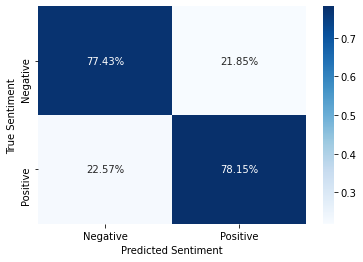

In [67]:
labels = ['Negative', 'Positive']
log_con_df = pd.DataFrame(confusion_log, index = labels,
                  columns = labels)
sns.heatmap(log_con_df/np.sum(log_con_df), annot=True, 
            fmt='.2%', cmap='Blues')
#sns.heatmap(log_con_df, annot=True)
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.savefig('logregcm.png')
plt.show()

MultinominalNB:

In [68]:
confusion_nb = confusion_matrix(y_test, pred_nb)
print("Confusion matrix:\n{}".format(confusion_nb))

Confusion matrix:
[[24578  7356]
 [ 7813 24253]]


In [69]:
print(classification_report(y_test,pred_nb))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76     31934
           4       0.77      0.76      0.76     32066

    accuracy                           0.76     64000
   macro avg       0.76      0.76      0.76     64000
weighted avg       0.76      0.76      0.76     64000



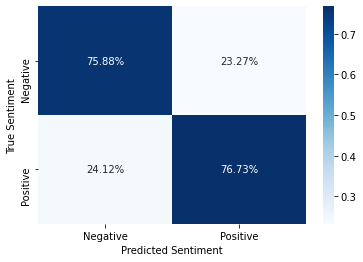

In [70]:
nb_con_df = pd.DataFrame(confusion_nb, index = labels,
                  columns = labels)
sns.heatmap(nb_con_df/np.sum(nb_con_df), annot=True, 
            fmt='.2%', cmap='Blues')
#sns.heatmap(log_con_df, annot=True)
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.savefig('nbcm.png')
plt.show()

In [ ]:
confusion_ranfor = confusion_matrix(y_test, pred_ranfor)
print("Confusion matrix:\n{}".format(confusion_ranfor))

### Model Coefficients

Logistic Regression Model best estimator the 20 most important features

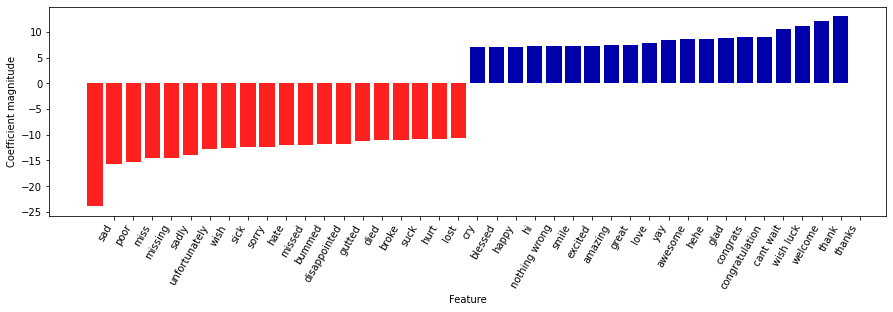

In [71]:
vect = gs_logreg.best_estimator_.named_steps['vect']
feature_names = np.array(vect.get_feature_names())
coef =gs_logreg.best_estimator_.named_steps['lr'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=20)

In [149]:
print(len(feature_names))

1135484
